In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from lammps_implicit_der.tools import plot_tools

In [29]:
delta = 0.40
num_cells = 3
method = 'inverse'

#path = '.'
path='/Users/imaliyov/run/potential-perturbation/HEA-one-shot'

filename = f'HEA_NiMo_{method}_{delta:.2f}_{num_cells:03d}.pkl'

# Load the output_dict
with open(os.path.join(path, filename) , 'rb') as f:
    output_dict = pickle.load(f)

# Unpack the output_dict
delta = output_dict['delta']
dTheta = output_dict['dTheta']
Theta_Ni = output_dict['Theta_Ni']
Theta_Mo = output_dict['Theta_Mo']
Theta_Mo_pert = output_dict['Theta_Mo_pert']
dX_dTheta = output_dict['dX_dTheta']
dX_pred = output_dict['dX_pred']
dX_true = output_dict['dX_true']
X_pred = output_dict['X_pred']
X_true = output_dict['X_true']
Natom = output_dict['Natom']
dX_dTheta = output_dict['dX_dTheta']
method = output_dict['method']
species = output_dict['species']
X0 = output_dict['X0']

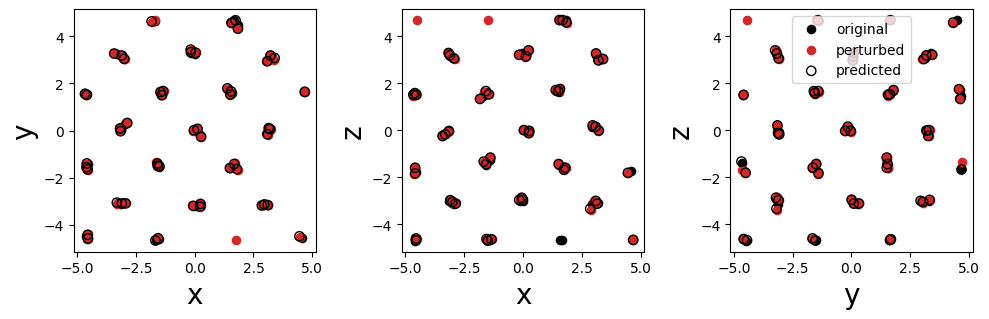

In [30]:
# Plot the coordinates
specie_color = {1: 'tab:orange', 2: 'tab:blue'}
specie_colors = [specie_color[s] for s in species]

color_list = ['black','tab:orange', 'tab:blue', 'black']
label_list = ['original', 'Ni', '$\delta$Mo', 'from dX/dTheta']

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

plot_tools.plot_coords(axes, X0.reshape(-1, 3), c='black', s=35, label='original')
plot_tools.plot_coords(axes, X_true.reshape(-1, 3), c='tab:red', s=35, label='perturbed')
plot_tools.plot_coords(axes, X_pred.reshape(-1, 3), s=45, label='predicted', facecolors='none', edgecolors='black', marker='o')
plt.tight_layout()
plt.show()

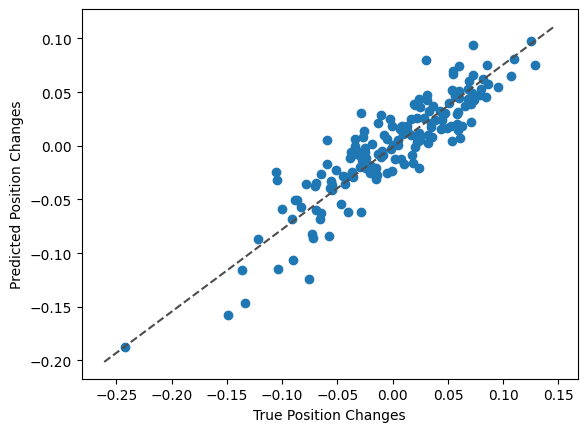

In [36]:
# Plot dX_true vs dX_pred
fig, ax = plt.subplots()
ax.plot(dX_true, dX_pred, 'o')
ax.set_xlabel('True Position Changes')
ax.set_ylabel('Predicted Position Changes')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

Text(0.5, 0, 'dX')

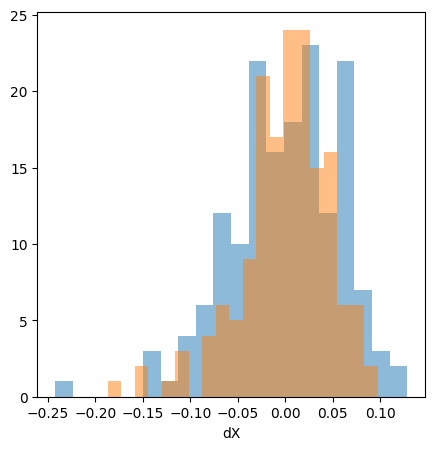

In [32]:
# plot histogram dX_pred vs dX_true
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(dX_true, bins=20, color='tab:blue', alpha=0.5, label='true')
ax.hist(dX_pred, bins=20, color='tab:orange', alpha=0.5, label='predicted')
ax.set_xlabel('dX')